### Imports

In [9]:
from os import path
from PIL import Image
import numpy as np

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.transforms import Bbox

from osgeo import gdal, osr, ogr
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
from fiona.crs import from_epsg
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString


from osgeo import gdal, osr
import numpy as np
import json
import sys


from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import shutil

import sys
sys.path.append("spacenet_lib")


### Define function to transform GeoJSON data to pixel data

In [2]:

def latlon2pixel(lat, lon, input_raster='', targetsr='', geom_transform=''):

    sourcesr = osr.SpatialReference()
    sourcesr.ImportFromEPSG(4326)

    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint(lon, lat)

    if targetsr == '':
        src_raster = gdal.Open(input_raster)
        targetsr = osr.SpatialReference()
        targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    coord_trans = osr.CoordinateTransformation(sourcesr, targetsr)
    if geom_transform == '':
        src_raster = gdal.Open(input_raster)
        transform = src_raster.GetGeoTransform()
    else:
        transform = geom_transform

    x_origin = transform[0]
    y_origin = transform[3]
    pixel_width = transform[1]
    pixel_height = transform[5]
    geom.Transform(coord_trans)
    x_pix = (geom.GetPoint()[0] - x_origin) / pixel_width
    y_pix = (geom.GetPoint()[1] - y_origin) / pixel_height

    return (x_pix, y_pix)

### Transform GeoJSON to Pixel Array

In [3]:
def geojson_to_pixel_arr(raster_file, geojson_file, pixel_ints=True, verbose=False):
	'''
	Tranform geojson file into array of points in pixel (and latlon) coords
	pixel_ints = 1 sets pixel coords as integers
	'''
	
	# load geojson file
	with open(geojson_file) as f:
		geojson_data = json.load(f)

	# load raster file and get geo transforms
	src_raster = gdal.Open(raster_file)
	targetsr = osr.SpatialReference()
	targetsr.ImportFromWkt(src_raster.GetProjectionRef())
		
	geom_transform = src_raster.GetGeoTransform()
	
	# get latlon coords
	latlons = []
	types = []
	for feature in geojson_data['features']:
		coords_tmp = feature['geometry']['coordinates'][0]
		type_tmp = feature['geometry']['type']
		if verbose: 
			print("features:", feature.keys())
			print("geometry:features:", feature['geometry'].keys())

		latlons.append(coords_tmp)
		types.append(type_tmp)
	
	# convert latlons to pixel coords
	pixel_coords = []
	latlon_coords = []
	for i, (poly_type, poly0) in enumerate(zip(types, latlons)):
		
		if poly_type.upper() == 'MULTIPOLYGON':
			for poly in poly0:
				poly=np.array(poly)
				if verbose:
					print("poly.shape:", poly.shape)
					
				# account for nested arrays
				if len(poly.shape) == 3 and poly.shape[0] == 1:
					poly = poly[0]
					
				poly_list_pix = []
				poly_list_latlon = []
				if verbose: 
					print("poly", poly)
				for coord in poly:
					if verbose: 
						print("coord:", coord)
					lon, lat, z = coord 
					px, py = latlon2pixel(lat, lon, input_raster=src_raster,
										 targetsr=targetsr, 
										 geom_transform=geom_transform)
					poly_list_pix.append([px, py])
					if verbose:
						print("px, py", px, py)
					poly_list_latlon.append([lat, lon])
				
				if pixel_ints:
					ptmp = np.rint(poly_list_pix).astype(int)
				else:
					ptmp = poly_list_pix
				pixel_coords.append(ptmp)
				latlon_coords.append(poly_list_latlon)            

		elif poly_type.upper() == 'POLYGON':
			poly=np.array(poly0)
			if verbose:
				print("poly.shape:", poly.shape)
				
			# account for nested arrays
			if len(poly.shape) == 3 and poly.shape[0] == 1:
				poly = poly[0]
				
			poly_list_pix = []
			poly_list_latlon = []
			if verbose: 
				print("poly", poly)
			for coord in poly:
				if verbose: 
					print("coord:", coord)
				lon, lat, z = coord 
				px, py = latlon2pixel(lat, lon, input_raster=src_raster,
									 targetsr=targetsr, 
									 geom_transform=geom_transform)
				poly_list_pix.append([px, py])
				if verbose:
					print("px, py", px, py)
				poly_list_latlon.append([lat, lon])
			
			if pixel_ints:
				ptmp = np.rint(poly_list_pix).astype(int)
			else:
				ptmp = poly_list_pix
			pixel_coords.append(ptmp)
			latlon_coords.append(poly_list_latlon)
			
		else:
			print("Unknown shape type in coords_arr_from_geojson()")
			return
			
	return pixel_coords, latlon_coords

### Transform GeoJSON to Masks

In [4]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
							noDataValue=0, burn_values=1):

	'''
	Create polygon mask for rasterSrc,
	Similar to labeltools/createNPPixArray() in spacenet utilities
	'''
	
	## open source vector file that truth data
	source_ds = ogr.Open(vectorSrc)
	source_layer = source_ds.GetLayer()

	## extract data from src Raster File to be emulated
	## open raster file that is to be emulated
	srcRas_ds = gdal.Open(rasterSrc)
	cols = srcRas_ds.RasterXSize
	rows = srcRas_ds.RasterYSize

	if npDistFileName == '':
		dstPath = ".tmp.tiff"
	else:
		dstPath = npDistFileName

	## create First raster memory layer, units are pixels
	# Change output to geotiff instead of memory 
	memdrv = gdal.GetDriverByName('GTiff') 
	dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
						   options=['COMPRESS=LZW'])
	dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
	dst_ds.SetProjection(srcRas_ds.GetProjection())
	band = dst_ds.GetRasterBand(1)
	band.SetNoDataValue(noDataValue)    
	gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
	dst_ds = 0

	mask_image = Image.open(dstPath)
	mask_image = np.array(mask_image)

	if npDistFileName == '':
		os.remove(dstPath)
		
	return mask_image

### Visualize data

./data_(1)/processedBuildingLabels/3band/3band_AOI_1_RIO_img1823.tif ./data_(1)/processedBuildingLabels/vectordata/geojson/Geo_AOI_1_RIO_img1823.geojson


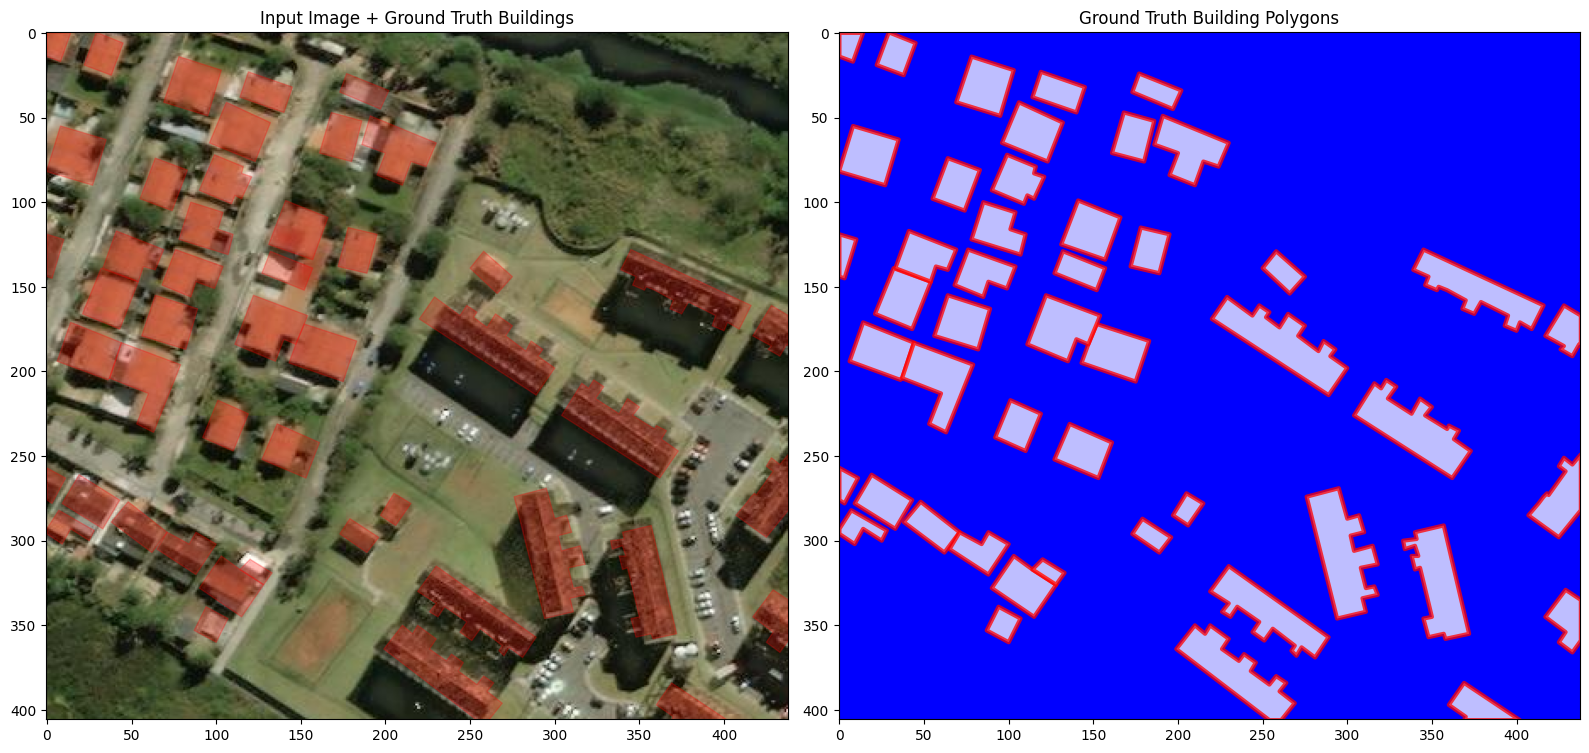

./data_(1)/processedBuildingLabels/3band/3band_AOI_1_RIO_img5865.tif ./data_(1)/processedBuildingLabels/vectordata/geojson/Geo_AOI_1_RIO_img5865.geojson


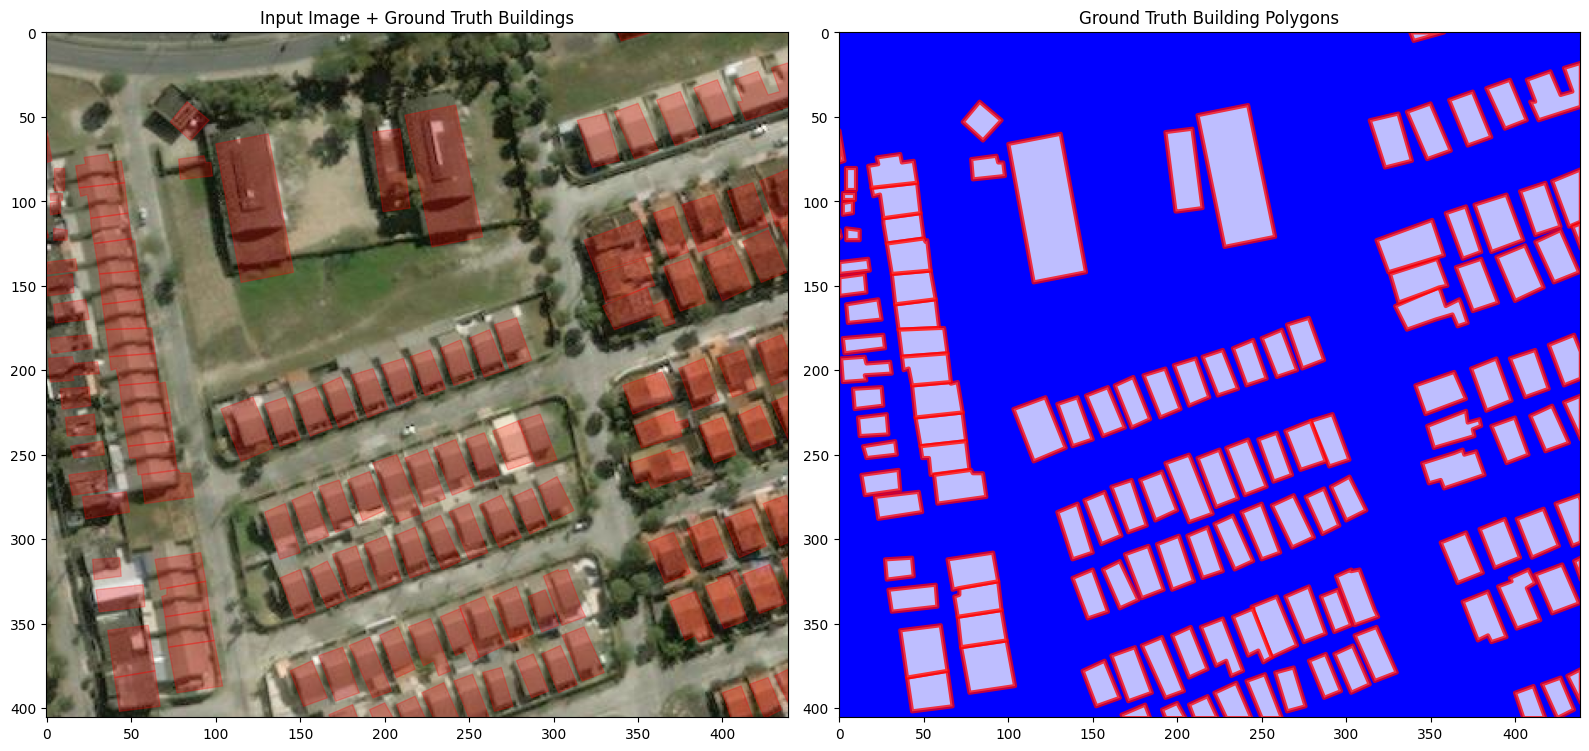

./data_(1)/processedBuildingLabels/3band/3band_AOI_1_RIO_img6046.tif ./data_(1)/processedBuildingLabels/vectordata/geojson/Geo_AOI_1_RIO_img6046.geojson


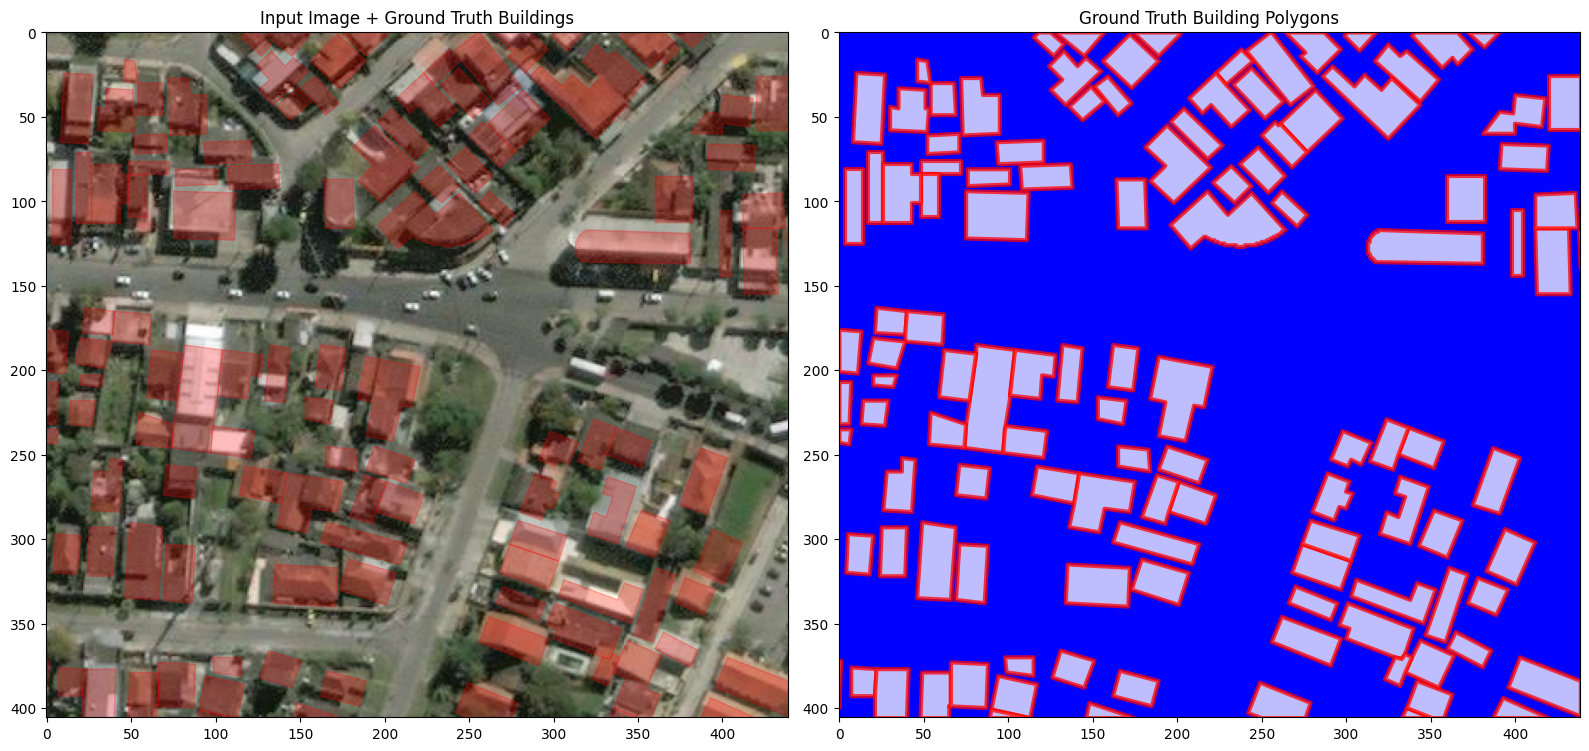

In [7]:
def plot_truth_coords(raster_path, pixel_coords,   
                      figsize=(8,8), plot_name='',
                      add_title=False, poly_face_color='red', 
                      poly_edge_color='red', poly_nofill_color='white', cmap='bwr'):
    '''
    Plot ground truth coordinaates
    pixel_coords should be a numpy array
    '''
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))
    
    if add_title:
        suptitle = fig.suptitle(plot_name.split('/')[-1], fontsize='large')
    
    # create patches
    patches = []
    patches_nofill = []
    if len(pixel_coords) > 0:
        # get patches    
        for coord in pixel_coords:
            patches_nofill.append(Polygon(coord, facecolor=poly_nofill_color, 
                                          edgecolor=poly_edge_color, lw=3))
            patches.append(Polygon(coord, edgecolor=poly_edge_color, fill=True, 
                                   facecolor=poly_face_color))
        p0 = PatchCollection(patches, alpha=0.25, match_original=True)
        p2 = PatchCollection(patches_nofill, alpha=0.75, match_original=True)
    plot_truth_coords
    # load raster file as numpy array
    raster = Image.open(raster_path)
    raster = np.asarray(raster)
    
    # ax0: raw image
    ax0.imshow(raster)
    if len(patches) > 0:
        ax0.add_collection(p0)
    ax0.set_title('Input Image + Ground Truth Buildings') 
    
    # truth polygons
    zero_arr = np.zeros(raster.shape[:2])
    # set background to white?
    #zero_arr[zero_arr == 0.0] = np.nan
    ax1.imshow(zero_arr, cmap=cmap)
    if len(patches) > 0:
        ax1.add_collection(p2)
    ax1.set_title('Ground Truth Building Polygons')
        
    #plt.axis('off')
    plt.tight_layout()
    if add_title:
        suptitle.set_y(0.95)
        fig.subplots_adjust(top=0.96)
 
    if len(plot_name) > 0:
        plt.savefig(plot_name)

    if plot_name == '':
        plot_name = 'output_image.png'
    current_fig = plt.gcf()
    plt.show()
    
    # Get the bounding box of ax1
    extent = ax1.get_window_extent().transformed(current_fig.dpi_scale_trans.inverted())
    current_fig.savefig(plot_name, bbox_inches=extent)

    return patches, patches_nofill

def get_filepaths(data_idx):
    # Modify the the paths based on your raster and geojson data location.
    raster_dir = './data/processedBuildingLabels/3band'
    geojson_dir = './data/processedBuildingLabels/vectordata/geojson/'
    
    raster_filename = '3band_AOI_1_RIO_img{}.tif'.format(data_idx)
    geojson_filename = 'Geo_AOI_1_RIO_img{}.geojson'.format(data_idx)
    
    return path.join(raster_dir, raster_filename), path.join(geojson_dir, geojson_filename)

def show(data_idx):
    raster_path, geojson_path = get_filepaths(data_idx)
    print(raster_path, geojson_path)
    pixel_coords, _ = geojson_to_pixel_arr(raster_path, geojson_path)
    
    plot_truth_coords(raster_path, pixel_coords)

for idx in [1823, 5865, 6046]:
    show(data_idx=idx)
    


### Build Building Mask Labels

In [8]:
def build_mask_labels(src_raster_dir, src_vector_dir, dst_dir):
	
	os.makedirs(dst_dir, exist_ok=True)

	file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

	print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

	for idx in tqdm(range(1, file_count + 1)):

		src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
		src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)

		src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
		src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
		dst_path = os.path.join(dst_dir, src_raster_filename)

		create_poly_mask(
			src_raster_path, src_vector_path, npDistFileName=dst_path, 
			noDataValue=0, burn_values=255
		)

src_raster_dir = "./data/processedBuildingLabels/3band"
src_vector_dir = "./data/processedBuildingLabels/vectordata/geojson"
dst_dir = "./data/buildingMaskLabels"
build_mask_labels(src_raster_dir, src_vector_dir, dst_dir)


[INFO] Found 6940 geojson files. Preparing building mask images...


100%|██████████| 6940/6940 [00:30<00:00, 224.24it/s]
